In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
import importlib
import time

from joblib import dump, load

from cv_sampler import *

np.warnings.filterwarnings('ignore')



In [2]:
import load_data
importlib.reload(load_data)

<module 'load_data' from '/home/matsui-k/projects/kaggle-lsst/scripts/load_data.py'>

In [4]:
gal_df, _, gal_target, _ = load_data.load_train()

In [5]:
gal_class_weight, gal_sample_weights, gal_target_i = load_data.get_weights(gal_target)

In [20]:
gal_importances = pd.DataFrame()
gal_lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'class_weight': gal_class_weight,
    'learning_rate': 0.035,
    'subsample': 0.95,
    'colsample_bytree': 0.34,
    'min_split_gain': 0.035,
    'min_child_weight': 1.1,
    'n_estimators': 3000,
    'max_depth': 2,
    'silent': False,
    'n_jobs': 2
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
param_list = []
score_list = []
for i_fold, (trn_index, val_index) in enumerate(folds.split(gal_target_i, gal_target_i)):
    trn_x, trn_y = gal_df.iloc[trn_index], gal_target_i.iloc[trn_index]
    val_x, val_y = gal_df.iloc[val_index], gal_target_i.iloc[val_index]

    gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
    gal_clf.fit(
        trn_x, trn_y,
        sample_weight=trn_y.map(gal_sample_weights),
        eval_set=[(val_x, val_y)],
        eval_metric='multi_logloss',
        eval_class_weight=[gal_class_weight],
        verbose=100,
        early_stopping_rounds=50
    )
    
    print(gal_clf.best_iteration_)

    imp_df = pd.DataFrame()
    imp_df['feature'] = gal_df.columns
    imp_df['gain'] = gal_clf.feature_importances_
    gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 0.272692
[200]	valid_0's multi_logloss: 0.129752
[300]	valid_0's multi_logloss: 0.0883605
[400]	valid_0's multi_logloss: 0.0695612
[500]	valid_0's multi_logloss: 0.0586609
[600]	valid_0's multi_logloss: 0.0530846
[700]	valid_0's multi_logloss: 0.0509944
[800]	valid_0's multi_logloss: 0.0491082
[900]	valid_0's multi_logloss: 0.0475826
[1000]	valid_0's multi_logloss: 0.0462339
Early stopping, best iteration is:
[1026]	valid_0's multi_logloss: 0.0460201
1026
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 0.299294
[200]	valid_0's multi_logloss: 0.165111
[300]	valid_0's multi_logloss: 0.132591
[400]	valid_0's multi_logloss: 0.12427
[500]	valid_0's multi_logloss: 0.119858
Early stopping, best iteration is:
[539]	valid_0's multi_logloss: 0.119275
539
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_logloss: 0.281644
[200]

In [14]:
gal_clf.best_score_

defaultdict(dict, {'training': {'multi_logloss': 0.0004962372452137583}})

In [16]:
gal_clf.best_iteration_

1653

In [24]:
gal_importances = pd.DataFrame()
gal_lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'class_weight': gal_class_weight,
    'learning_rate': 0.035,
    'subsample': 0.95,
    'colsample_bytree': 0.34,
    'min_split_gain': 0.035,
    'min_child_weight': 1.1,
    'n_estimators': 3000,
    'max_depth': 2,
    'silent': False,
    'n_jobs': 2,
    'num_iterations': 600
}

trn_x = gal_df
trn_y = gal_target_i
param_list = []
score_list = []
gal_clf = lgb.LGBMClassifier(**gal_lgb_params)
gal_clf.fit(
    trn_x, trn_y,
    sample_weight=trn_y.map(gal_sample_weights),
    eval_set=[(trn_x, trn_y)],
    eval_metric='multi_logloss',
    eval_class_weight=[gal_class_weight],
    verbose=100
)

print(gal_clf.best_iteration_)

imp_df = pd.DataFrame()
imp_df['feature'] = gal_df.columns
imp_df['gain'] = gal_clf.feature_importances_
gal_importances = pd.concat([gal_importances, imp_df], axis=0, sort=False)


[100]	training's multi_logloss: 0.217784
[200]	training's multi_logloss: 0.0835222
[300]	training's multi_logloss: 0.0425997
[400]	training's multi_logloss: 0.025402
[500]	training's multi_logloss: 0.0157808
[600]	training's multi_logloss: 0.0104054
None


In [25]:
gal_importances

feature  gain
0            flux_min    63
1            flux_max    35
2           flux_mean    44
3         flux_median    73
4            flux_std   115
5           flux_skew   191
6        flux_err_min   270
7        flux_err_std   160
8       detected_mean    87
9       flux_kurtosis   172
10          flux_diff    34
11    flux_abs_median    97
12    flux_diff_dbmed    53
13     flux_max_dbmed   109
14     flux_min_dbmed   186
15         flux_min_0    42
16         flux_min_1   126
17         flux_min_2   106
18         flux_min_3   119
19         flux_min_4    82
20         flux_min_5   118
21         flux_max_0    73
22         flux_max_1    95
23         flux_max_2    87
24         flux_max_3    37
25         flux_max_4     7
26         flux_max_5    80
27        flux_mean_0    60
28        flux_mean_1     9
29        flux_mean_2    88
..                ...   ...
59      flux_absmed_2    79
60      flux_absmed_3    13
61      flux_absmed_4    54
62      flux_absmed_5   165
63        flux_diff_0    85
64        flux_diff_1    67
65        flux_diff_2    51
66        flux_diff_3    11
67        flux_diff_4    69
68        flux_diff_5   150
69  flux_diff_dbmed_0    52
70  flux_diff_dbmed_1    29
71  flux_diff_dbmed_2    40
72  flux_diff_dbmed_3    26
73  flux_diff_dbmed_4    18
74  flux_diff_dbmed_5    30
75   flux_max_dbmed_0    61
76   flux_max_dbmed_1    97
77   flux_max_dbmed_2   143
78   flux_max_dbmed_3    87
79   flux_max_dbmed_4    48
80   flux_max_dbmed_5    78
81   flux_min_dbmed_0   138
82   flux_min_dbmed_1    48
83   flux_min_dbmed_2    75
84   flux_min_dbmed_3    36
85   flux_min_dbmed_4   113
86   flux_min_dbmed_5    51
87        best_period   862
88              score   265

[89 rows x 2 columns]

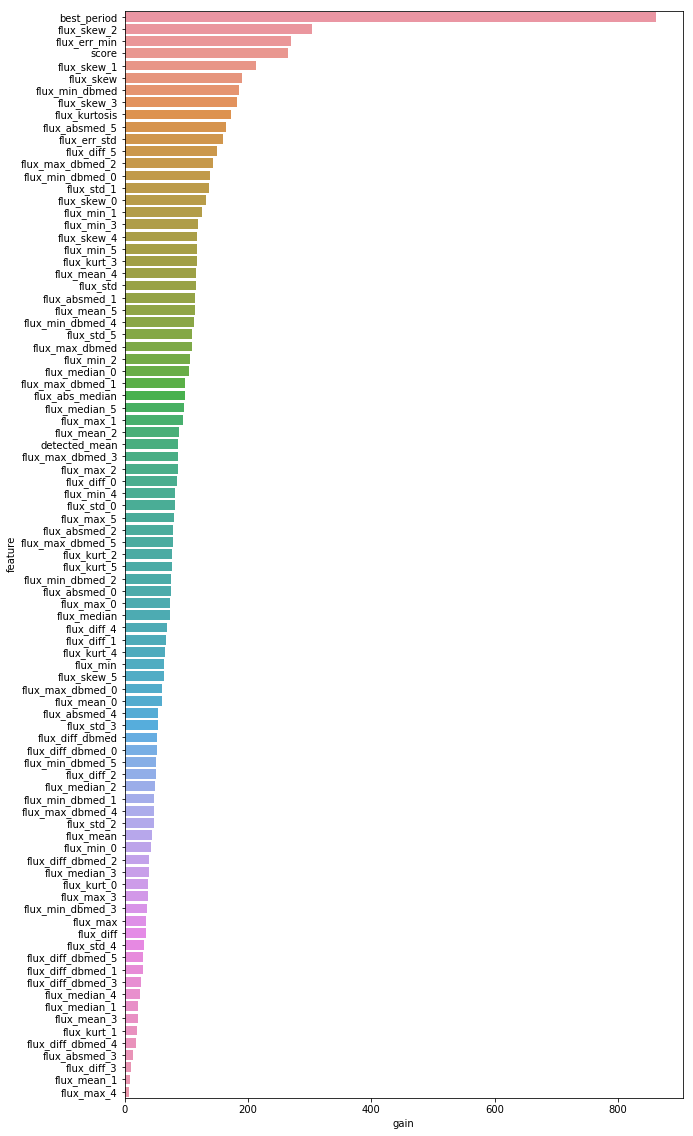

In [29]:
plt.figure(figsize=(10, 20))
sns.barplot(x='gain', y='feature', data=gal_importances.sort_values('gain', ascending=False))

In [30]:
dump(gal_clf, '../models/gal_clf12081220.joblib')

['../models/gal_clf12081220.joblib']

In [31]:
clf = load('../models/gal_clf12081220.joblib')

In [32]:
clf

LGBMClassifier(boosting_type='gbdt',
        class_weight={0: 1, 1: 1, 2: 1, 3: 1, 4: 1}, colsample_bytree=0.34,
        importance_type='split', learning_rate=0.035, max_depth=2,
        metric='multi_logloss', min_child_samples=20, min_child_weight=1.1,
        min_split_gain=0.035, n_estimators=3000, n_jobs=2, num_class=5,
        num_iterations=600, num_leaves=31, objective='multiclass',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=0.95, subsample_for_bin=200000, subsample_freq=0)